# COVID Respiratory Modeling
In this notebook we will implement the mathematical model for viral particle deposition in the respiratory tract.

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import fsolve

## Parameters
Values for the Airflow, Virus and Generation Characteristics. **Described in SI units.** 

In [97]:
# Airflow characteristics
rho_f = 1.2*10**(-4) # g cm^-3
mu = 1.81*10**(-4) # g cm^-1 s^-1
Q0 = 30 # L min^-1
g = 980 # cm s^-2
lamda = 0.066*10**(-4) # cm
K_b = 1.38*10**(-16) # cm^2 g s^-2 K^-1
T = 298 # K


# Virus characteristics
C0 = 10^7 # Copies/mL
# A = 
d_p = 60 # nm
rho_p = 1.18 # g cm^-3
p = 8.2 # day^-1
c = 0.6 # day^-1
b = 3.9*10**(-7) # (Copies/mL)^-1 day^-1
d = 4.71 # day^-1

# Generation characteristics
final_generation = 23

lengths = [12, 4.76, 1.9, 1.76, 1.27, 1.07, 0.9, 0.76, 0.64, 0.54, 0.46, 0.39, 0.33, 0.27, 0.23, 0.2, 0.165, 0.14, 0.12, 0.099, 0.083, 0.07, 0.059, 0.05]
diameters = [1.8, 1.22, 0.83, 0.56, 0.45, 0.35, 0.28, 0.23, 0.186, 0.154, 0.13, 0.109, 0.095, 0.082, 0.074, 0.061, 0.06, 0.054, 0.05, 0.047, 0.045, 0.043, 0.041, 0.04]



In [98]:
# SI units: 

# Airflow characteristics
rho_f = rho_f*1000 # kg m^-3
mu = mu*0.1 # kg m^-1 s^-1 
Q0 = Q0*1.667*10**-5 # m^3 s^-1
g = g*0.01 #m s^-1
lamda = lamda*0.01 #m
K_b = K_b*10**-7 # m^2 kg s^-2 K^-1
T = T # K

# Virus characteristics

C0 = C0*10**6 # Copies/m^3
d_p = d_p*10**-9 # m
rho_p = rho_p*1000 # kg m^-3
p = p/86400 # s^-1
c = c/86400 # s^-1
b = b*10**-6/86400 # (Copies/m^3)^-1 s^-1
d = d/86400 # s^-1

# Generation characteristics

lengths_SI = [0.01*element for element in lengths]
diameters_SI = [0.01*element for element in diameters]

In [113]:
print(diffusivity(d_p))

4.017856279748988e-10


## 1. Fluid Velocity and Airflow Rate

In [99]:
def velocity(Q,d):
    A = np.pi*(d/2)**2
    u = Q/A
    return u

In [100]:
Q = {} #Dictionary for the flow rate
u = {} #Dictionary for the velocities
Q[0] = Q0
u[0] = velocity(Q0,diameters_SI[0])
for i in range(1,final_generation+1):
        Q[i] = Q[i-1]/2
        u[i] = velocity(Q[i],diameters_SI[i])
#print(u)

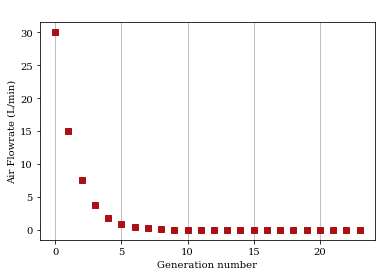

In [101]:
# PLOT AIRFLOW RATE

#Change Q to L min^-1
Q_paper = [60000*Q[i] for i in range(final_generation+1)]

sns.reset_orig()
sns.set_palette(sns.color_palette())
sns.set_color_codes()
sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

reds = sns.color_palette("Reds")
reds.reverse()

fig_flow, ax_flow = plt.subplots()
ax_flow.set_title(" ")
ax_flow.set_ylabel("Air Flowrate (L/min)")
ax_flow.set_xlabel("Generation number")
#ax_flow.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=myhandles, labels=mylabels)
#ax_flow.set(xlim=(11.4, 4.6))
#ax_flow.set(ylim=(50, 95))
ax_flow.xaxis.grid()

final_colors = [reds[0]]
final_lines = ['-']
final_markers = ['s']
final_labels = ["label"]
for i in range(final_generation+1):
    ax_flow.plot(i, Q_paper[i], color=final_colors[0],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])   
#fig_flow.savefig(os.path.join(outputdir, "Pressure_along_path_600dpi"), bbox_inches='tight', dpi=600)

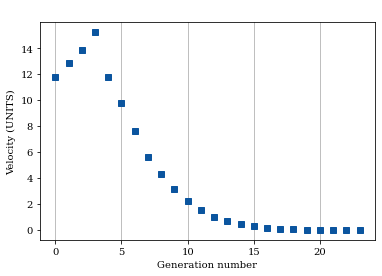

In [102]:
# PLOT VELOCITY

#Change u to 10^3 cm min^-1
u_paper = [6*u[i] for i in range(final_generation+1)]


sns.reset_orig()
sns.set_palette(sns.color_palette())
sns.set_color_codes()
sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

blues = sns.color_palette("Blues")
blues.reverse()

fig_flow, ax_flow = plt.subplots()
ax_flow.set_title(" ")
ax_flow.set_ylabel("Velocity (UNITS)")
ax_flow.set_xlabel("Generation number")
#ax_flow.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=myhandles, labels=mylabels)
#ax_flow.set(xlim=(11.4, 4.6))
#ax_flow.set(ylim=(50, 95))
ax_flow.xaxis.grid()

final_colors = [blues[0]]
final_lines = ['-']
final_markers = ['s']
final_labels = ["label"]
for i in range(final_generation+1):
    ax_flow.plot(i, u_paper[i], color=final_colors[0],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])   
#fig_flow.savefig(os.path.join(outputdir, "Pressure_along_path_600dpi"), bbox_inches='tight', dpi=600)

## 2. Deposition
Impaction, Sedimentation and Diffusion

In [114]:
# Functions

def impaction(L,d,u):
    k_I = (1.3*rho_p*d_p**2*u)/(L*18*mu*d)
    return k_I


def beta_sedimentation(L,d,u):
    B = (3*np.pi*L*u_g)/16*u*d
    return B

def sedimentation(L,d,Q,u):
    B = beta_sedimentation(L,d,u)
    k_S = ((2*Q)/(np.pi*L)) * (2*B*sqrt(1-B**(2/3)) - B**(1/3)*sqrt(1-B**(2/3)) + sin(B**(1/3))**(-1)) 
    return k_S

def diffusivity(d_p):
    D = (K_b*T)/(3*np.pi*mu*d_p)
    return D

def beta_diffusion(L,Q):
    D = diffusivity(d_p)
    B = np.pi*D*L/(4*Q)
    return B

def diffusion(L,Q):
    B = beta_diffusion(L,Q)
    k_d = 1 - 0.819*np.exp(-14.63*B) - 0.0976*np.exp(-89.22*B) - 0.0325*np.exp(-228*B) - 0.0509*np.exp(-125.9*B**(2/3))
    return k_d


In [104]:
#Re_p = rho_f*u_g*d_p/mu
#C_D = (24/Re_p)*(1 + 0.15*Re_p**0.687)
#C_c = 1 + (2*lamda/d_p)*(1.257+0.4*np.exp((-1.1*d_p)/(2*lamda)))

#func = lambda u_g : - u_g - (4*C_c*d_p**2*rho_p*(rho_p-rho_f)*g)/(3*mu*C_D*Re_p*rho_f)

func = lambda u_g : u_g - (4*(1 + (2*lamda/d_p)*(1.257+0.4*np.exp((-1.1*d_p)/(2*lamda))))*d_p**2*rho_p*(rho_p-rho_f)*g)/(3*mu*((24/(rho_f*u_g*d_p/mu))*(1 + 0.15*(rho_f*u_g*d_p/mu)**0.687))*(rho_f*u_g*d_p/mu)*rho_f)

# Plot it
'''
x_axes = np.linspace(-10, 10, 201)

plt.plot(x_axes, func(x_axes))
plt.xlabel("u_g")
plt.ylabel("expression value")
plt.grid()
plt.show()
'''

# Use the numerical solver to find the roots

u_g_initial_guess = 0.5
u_g = fsolve(func, u_g_initial_guess)

print("The solution is tau = %f" % u_g)
print("at which the value of the expression is %f" % func(u_g))

The solution is tau = 0.005401
at which the value of the expression is 0.000000


In [115]:
# Find deposition for each generation

k_I = {}
k_d = {}
for i in range(0,final_generation+1):
        k_I[i] = impaction(lengths_SI[i],diameters_SI[i],u[i])
        k_d[i] = diffusion(lengths_SI[i],Q[i])



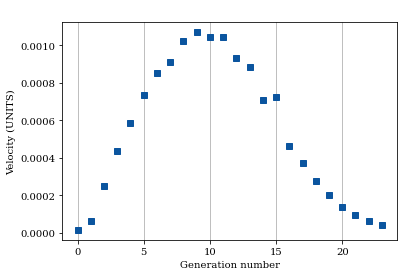

In [116]:
sns.reset_orig()
sns.set_palette(sns.color_palette())
sns.set_color_codes()
sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

blues = sns.color_palette("Blues")
blues.reverse()

fig_flow, ax_flow = plt.subplots()
ax_flow.set_title(" ")
ax_flow.set_ylabel("Velocity (UNITS)")
ax_flow.set_xlabel("Generation number")
#ax_flow.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=myhandles, labels=mylabels)
#ax_flow.set(xlim=(11.4, 4.6))
#ax_flow.set(ylim=(50, 95))
ax_flow.xaxis.grid()

final_colors = [blues[0]]
final_lines = ['-']
final_markers = ['s']
final_labels = ["label"]
for i in range(final_generation+1):
    ax_flow.plot(i, k_I[i], color=final_colors[0],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])   
#fig_flow.savefig(os.path.join(outputdir, "Pressure_along_path_600dpi"), bbox_inches='tight', dpi=600)

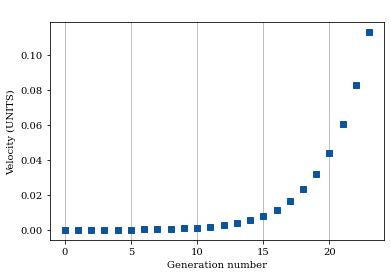

In [117]:
sns.reset_orig()
sns.set_palette(sns.color_palette())
sns.set_color_codes()
sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

blues = sns.color_palette("Blues")
blues.reverse()

fig_flow, ax_flow = plt.subplots()
ax_flow.set_title(" ")
ax_flow.set_ylabel("Velocity (UNITS)")
ax_flow.set_xlabel("Generation number")
#ax_flow.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=myhandles, labels=mylabels)
#ax_flow.set(xlim=(11.4, 4.6))
#ax_flow.set(ylim=(50, 95))
ax_flow.xaxis.grid()

final_colors = [blues[0]]
final_lines = ['-']
final_markers = ['s']
final_labels = ["label"]
for i in range(final_generation+1):
    ax_flow.plot(i, k_d[i], color=final_colors[0],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])   
#fig_flow.savefig(os.path.join(outputdir, "Pressure_along_path_600dpi"), bbox_inches='tight', dpi=600)